In [4]:
# from hugging face 
!pip3 install diffusers  

In [5]:
pip install -U transformers

     ---------------------------------------- 8.4/8.4 MB 44.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.1
    Uninstalling transformers-4.37.1:
      Successfully uninstalled transformers-4.37.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip3 install datasets

In [7]:
pip install accelerate


Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

In [2]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [11]:
from torch.utils.data import Dataset
import pandas as pd
from skimage import io
import os

df_train = 'C:/dataset/audio_post_train.csv' # chnage 
df_val  = 'C:/dataset/face_post_test.csv'
class BabyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations.iloc[2748:]	# remove for full data	
        #self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path =  self.annotations.iloc[idx, 0]
        image = io.imread(img_path)
        
        if self.transform:
          image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32)

        # image = image.detach().clone()
        # image = image.type(torch.float)
        y_label = self.annotations.iloc[idx, 1]
        y_label = np.array(y_label)
        y_label = y_label.astype('int')
        y_label = y_label.tolist()
        return image, y_label

In [26]:
# transform 
trans = transforms.Compose([
  #transforms.ToTensor(),
  transforms.ToPILImage(),
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.6414, 0.8491, 0.6575], std=[0.3448, 0.1205, 0.3073]) 
])

#DataLoader 
train_set = BabyDataset(csv_file = df_train,  transform= trans)
print ('train data', len(train_set))

train_dataloader = DataLoader(dataset=train_set, batch_size= 16, shuffle=True)


train data 2684


In [27]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features [0].shape}")
print(f"Labels batch shape: {train_labels [1].shape}")

Feature batch shape: torch.Size([3, 224, 224])
Labels batch shape: torch.Size([])


C:\Users\imran\AppData\Local\Temp\ipykernel_2512\1924913161.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


C:\Users\imran\AppData\Local\Temp\ipykernel_2512\1924913161.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


0 tensor([[[1.0400, 1.0400, 1.0400,  ..., 1.0400, 1.0400, 1.0400],
         [1.0400, 1.0400, 1.0400,  ..., 1.0400, 1.0400, 1.0400],
         [1.0400, 1.0400, 1.0400,  ..., 1.0400, 1.0400, 1.0400],
         ...,
         [1.0400, 1.0400, 1.0400,  ..., 1.0400, 1.0400, 1.0400],
         [1.0400, 1.0400, 1.0400,  ..., 1.0400, 1.0400, 1.0400],
         [1.0400, 1.0400, 1.0400,  ..., 1.0400, 1.0400, 1.0400]],

        [[1.2523, 1.2523, 1.2523,  ..., 1.2523, 1.2523, 1.2523],
         [1.2523, 1.2523, 1.2523,  ..., 1.2523, 1.2523, 1.2523],
         [1.2523, 1.2523, 1.2523,  ..., 1.2523, 1.2523, 1.2523],
         ...,
         [1.2523, 1.2523, 1.2523,  ..., 1.2523, 1.2523, 1.2523],
         [1.2523, 1.2523, 1.2523,  ..., 1.2523, 1.2523, 1.2523],
         [1.2523, 1.2523, 1.2523,  ..., 1.2523, 1.2523, 1.2523]],

        [[1.1145, 1.1145, 1.1145,  ..., 1.1145, 1.1145, 1.1145],
         [1.1145, 1.1145, 1.1145,  ..., 1.1145, 1.1145, 1.1145],
         [1.1145, 1.1145, 1.1145,  ..., 1.1145, 1.1145, 

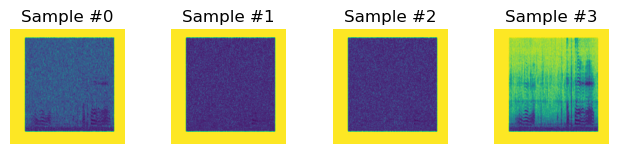

In [28]:
for i in range(0, len(train_set)):
    sample = train_set[i]
    print(i, sample[0], sample[1])

   # print( i, sample[i].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0][2]) # image
    print(sample[1]) #label
    if i == 3:
        plt.show()
        break

In [29]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [30]:
train_features, train_labels = next(iter(train_dataloader))
sample_image = train_features [0].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)


C:\Users\imran\AppData\Local\Temp\ipykernel_2512\1924913161.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Input shape torch.Size([1, 3, 224, 224])
Output shape torch.Size([1, 3, 224, 224])


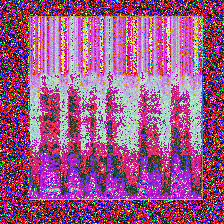

In [31]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [32]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.0386, device='cuda:0', grad_fn=<MseLossBackward0>)


In [33]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, (data, target) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        # print('xxx', idx)
        # print('xxx', data)
        # print('xxx', target)

        clean_images = data.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")